In [1]:
# Imports 
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
import numpy as np

In [3]:
leagues = ['La_liga', 'EPL', 'Bundesliga', 'Serie_A', 'Ligue_1', 'RFPL']

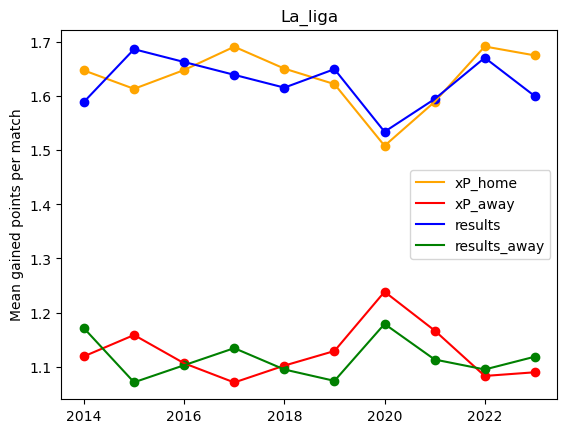

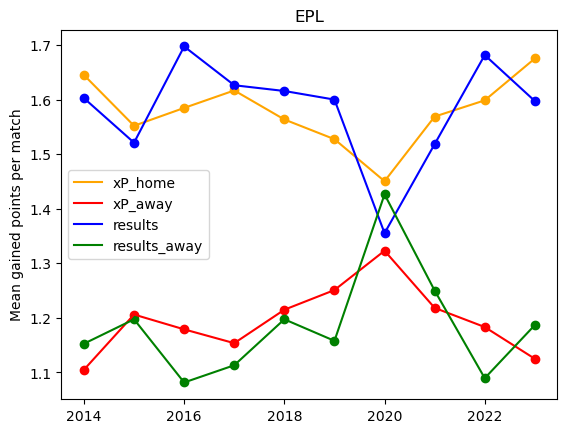

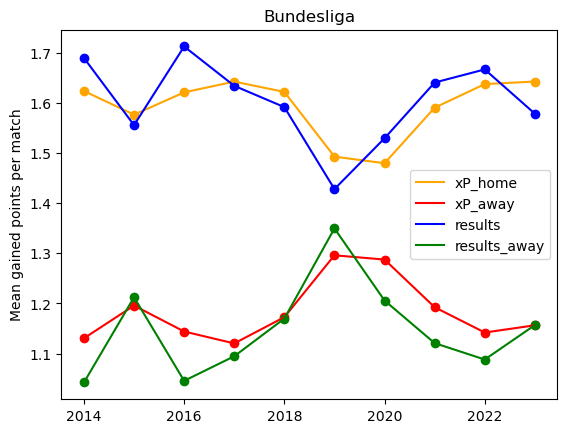

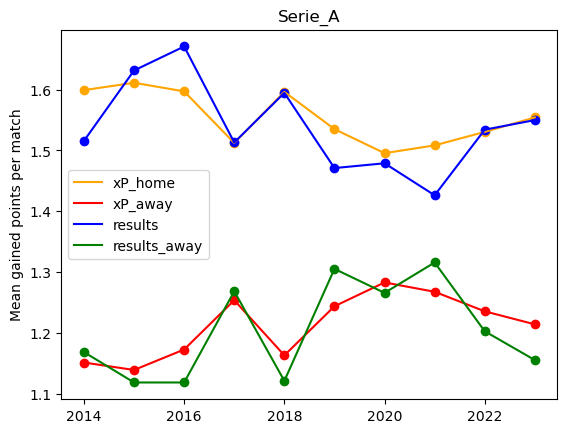

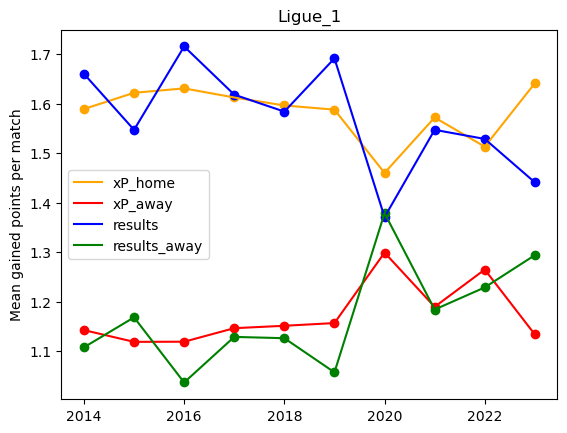

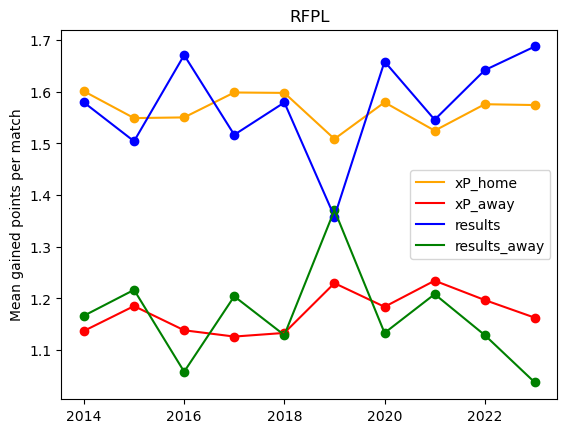

In [5]:
def create_graph(league):
    data = pd.read_csv(os.path.join('data_leagues', league + '.csv'))

    # Extraire les probabilités de forecast
    data['forecast_home'] = data['forecast'].apply(lambda x: eval(x))
    data['forecast_away'] = data['forecast'].apply(lambda x: eval(x))
    data['goals'] = data['goals'].apply(lambda x: eval(x))

    # Calculer les points attendus (xP) pour domicile et extérieur
    data['xP_home'] = data['forecast_home'].apply(lambda f: 3 * float(f['w']) + 1 * float(f['d']))
    data['xP_away'] = data['forecast_away'].apply(lambda f: 3 * float(f['l']) + 1 * float(f['d']))
    data['results'] = data['goals'].apply(lambda f: 3 if float(f['h']) > float(f['a']) else 1 if float(f['h']) == float(f['a']) else 0)
    data['results_away'] = data['goals'].apply(lambda f: 3 if float(f['a']) > float(f['h']) else 1 if float(f['h']) == float(f['a']) else 0)


    # Calculer la moyenne de xP pour les équipes à domicile et à l'extérieur par saison
    average_xP_home = data.groupby('year')['xP_home'].mean()
    average_xP_away = data.groupby('year')['xP_away'].mean()
    average_results = data.groupby('year')['results'].mean()
    average_results_away = data.groupby('year')['results_away'].mean()

    #Création graphe
    fig, ax = plt.subplots()
    plt.title(league)
    ax.plot(average_xP_home.index, average_xP_home, color="orange", label="xP_home")
    ax.scatter(average_xP_home.index, average_xP_home, color="orange", marker="o")
    ax.plot(average_xP_away.index, average_xP_away, color="red", label="xP_away")
    ax.scatter(average_xP_away.index, average_xP_away, color="red", marker="o")
    ax.plot(average_results.index, average_results, color="blue", label="results")
    ax.scatter(average_results.index, average_results, color="blue", marker="o")
    ax.plot(average_results_away.index, average_results_away, color="green", label="results_away")
    ax.scatter(average_results_away.index, average_results_away, color="green", marker="o")

    plt.ylabel("Mean gained points per match")
    plt.legend(fontsize=10)
    plt.show()
for league in leagues:
    create_graph(league)

In [6]:
def diff_points(leagues):
    df_leagues = pd.DataFrame()
    df_results = pd.DataFrame()
    for league in leagues:
        data = pd.read_csv(os.path.join('data_leagues', league + '.csv'))
        data['forecast_home'] = data['forecast'].apply(lambda x: eval(x))
        data['forecast_away'] = data['forecast'].apply(lambda x: eval(x))
        data['goals'] = data['goals'].apply(lambda x: eval(x))

        data['xP_home'] = data['forecast_home'].apply(lambda f: 3 * float(f['w']) + 1 * float(f['d']))
        data['xP_away'] = data['forecast_away'].apply(lambda f: 3 * float(f['l']) + 1 * float(f['d']))
        data['results'] = data['goals'].apply(lambda f: 3 if float(f['h']) > float(f['a']) else 1 if float(f['h']) == float(f['a']) else 0)
        data['results_away'] = data['goals'].apply(lambda f: 3 if float(f['a']) > float(f['h']) else 1 if float(f['h']) == float(f['a']) else 0)

        data['xG_home'] = data['xG'].apply(lambda x: float(eval(x)['h']))
        data['xG_away'] = data['xG'].apply(lambda x: float(eval(x)['a']))

        data['league'] = league
        data['year'] = data['year']

        df_results = pd.concat([df_results, data[['league', 'year', 'results', 'results_away', 'xP_home', 'xP_away', 'xG_home', 'xG_away']]], ignore_index=True)

        results_home = data.groupby('year')['results'].sum()
        results_away = data.groupby('year')['results_away'].sum()
        xp_home = data.groupby('year')['xP_home'].sum()
        xp_away = data.groupby('year')['xP_away'].sum()
        
        df = pd.DataFrame()
        df["diff_points"] = results_home - results_away
        df["diff_points_xp"] = xp_home - xp_away
        df["league"] = league
        df["year"] = df.index
        df.reset_index(drop=True, inplace=True)
        df_leagues = pd.concat([df_leagues, df], ignore_index=True)

    df_leagues.set_index('league', inplace=True)
    df_leagues.set_index('year', append=True, inplace=True)
    return df_leagues, df_results
    #.relabel_index(["row 1", "row 2"], axis=0)

def style_formatter(leagues):
    df_leagues,_ = diff_points(leagues)
    return df_leagues.style \
    .format(precision=0, thousands=".", decimal=",") \
    .format_index(str.upper, axis=1) \
    .bar(subset= ["diff_points", "diff_points_xp"], color = ['#b0351a', '#069215'], align=0, vmin=df_leagues["diff_points"].min(), vmax=df_leagues["diff_points"].max(), height=60,
         width=80, props="width: 200px; border-right: 1px solid black;")

style_formatter(leagues)

In [7]:
def cohen_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    s_pooled = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
    
    d = (mean1 - mean2) / s_pooled
    return d

def perform_statistical_tests_on_results(df):
    results = []
    grouped = df.groupby('league')
    for league, group in grouped:
        for year in group['year'].unique():
            subset = group[group['year'] == year]
            if len(subset) < 2:  
                continue
            
            home_results = subset['results']
            away_results = subset['results_away']
            home_xPoints = subset['xP_home']
            away_xPoints = subset['xP_away']
            home_xG = subset['xG_home']
            away_xG = subset['xG_away']
            
            wilco_result, wilco_result_pvalue = stats.wilcoxon(home_results, away_results)
            wilco_xPoints, wilco_xPoints_pvalue = stats.wilcoxon(home_xPoints, away_xPoints)
            wilco_xG, wilco_xG_pvalue = stats.wilcoxon(home_xG, away_xG)
            
            results.append({
                'league': league,
                'year': year,
                'wilco-result': wilco_result,
                'wilco-result-pvalue': wilco_result_pvalue,
                'result-cohend': cohen_d(home_results, away_results),
                'wilco-xPoints' : wilco_xPoints,
                'wilco-xPoints-pvalue': wilco_xPoints_pvalue,
                'xPoints-cohend': cohen_d(home_xPoints, away_xPoints),
                'wilco-xG': wilco_xG,
                'wilco-xG-pvalue': wilco_xG_pvalue,
                'xG-cohend' : cohen_d(home_xG, away_xG)
            })
    
    results_df = pd.DataFrame(results)
    return results_df

def style_formatter_proba(dataframe):
    # Fonction pour la coloration conditionnelle

    def color_wilco(val):
        color = 'red' if val > 0.05 else ''
        return f'color: {color};'
    
    def color_cohend(val):
        color = '#F4C430' if val < 0.2 else ''
        return f'background-color: {color}'

    def zebra_style(row_index):
        return "background-color: #f8f9fa;" if row_index % 2 == 0 else "background-color: white;"


    # Application du style combiné
    return (
        dataframe.style
        .format(precision=2, decimal=",")
        .format_index(str.upper, axis=1)
        # Appliquer une alternance de couleurs sur les lignes (zebra-striping)
        .apply(lambda row: [zebra_style(row.name)] * len(dataframe.columns), axis=1)
        # Texte noir par défaut
        .set_properties(**{"color": "black", "font-family": "Times New Roman", "font-size": "1.3em"})
        .map(color_wilco, subset=["wilco-result-pvalue", "wilco-xPoints-pvalue", "wilco-xG-pvalue"])
        .map(color_cohend, subset=["result-cohend", "xPoints-cohend", "xG-cohend"])
    )

_, df_leagues = diff_points(leagues)
results_df = perform_statistical_tests_on_results(df_leagues)
style_formatter_proba(results_df)

,LEAGUE,YEAR,WILCO-RESULT,WILCO-RESULT-PVALUE,RESULT-COHEND,WILCO-XPOINTS,WILCO-XPOINTS-PVALUE,XPOINTS-COHEND,WILCO-XG,WILCO-XG-PVALUE,XG-COHEND
0,Bundesliga,2014,"8887,50","0,00","0,51","15127,50","0,00","0,66","15014,00","0,00","0,49"
1,Bundesliga,2015,"11800,00","0,02","0,26","17547,00","0,00","0,46","17430,00","0,00","0,40"
2,Bundesliga,2016,"9553,00","0,00","0,52","15789,50","0,00","0,60","15813,00","0,00","0,47"
3,Bundesliga,2017,"9408,00","0,00","0,42","14812,50","0,00","0,67","14736,00","0,00","0,51"
4,Bundesliga,2018,"11115,00","0,00","0,32","16635,00","0,00","0,52","16636,00","0,00","0,40"
5,Bundesliga,2019,"13742,50","0,60","0,06","20412,50","0,05","0,23","20551,00","0,06","0,17"
6,Bundesliga,2020,"10848,00","0,03","0,25","20471,00","0,05","0,23","20344,00","0,04","0,22"
7,Bundesliga,2021,"10530,00","0,00","0,40","17146,00","0,00","0,48","17281,00","0,00","0,33"
8,Bundesliga,2022,"9976,00","0,00","0,45","15665,50","0,00","0,60","15673,00","0,00","0,46"
9,Bundesliga,2023,"10283,00","0,00","0,33","16091,00","0,00","0,57","16040,00","0,00","0,46"


In [46]:
def mann_whitney_u_test_on_seasons(df):
    results = []
    
    for league, group in df.groupby('league'):
        years = group['year'].unique()
        
        for i in range(len(years)):
            for j in range(i + 1, len(years)):
                year_1 = years[i]
                year_2 = years[j]
                
                data_1 = group[group['year'] == year_1]['xP_home']
                data_2 = group[group['year'] == year_2]['xP_home']
                
                stat, p_value = stats.mannwhitneyu(data_1, data_2)
                
                results.append({
                    'league': league,
                    'year_1': year_1,
                    'year_2': year_2,
                    'p_value': p_value
                })
    
    results_df = pd.DataFrame(results)
    
    return results_df



# Fonction de style conditionnel
def highlight_pval(val):
    if val == "":  # Ignorer les cellules vides
        return ''
    elif isinstance(val, (float, int)) and val < 0.10:  # P-values significatives
        return 'color: red; font-weight: bold;'
    else:
        return 'color: white;'



results_df = mann_whitney_u_test_on_seasons(df_leagues)
print(results_df.head(187))
for league, group in results_df.groupby('league'):
    pivot_df = group.pivot(index='year_2', columns='year_1', values='p_value')
    pivot_df.columns.name = None  # Supprime le nom de l'index des colonnes
    pivot_df.index.name = None  # Supprime le nom de l'index des lignes
    pivot_df = pivot_df.fillna("")
    #pivot_df = pivot_df.mask(np.eye(pivot_df.shape[0], dtype=bool))
    # Appliquer le style
    styled_df = pivot_df.style.map(highlight_pval)
    styled_df = (
        pivot_df.style
        .map(highlight_pval)  # Appliquer le style conditionnel
        .set_table_styles(
            [
                {'selector': 'th', 'props': 'border: 1px solid white; font-weight: bold;'},
                {'selector': 'td', 'props': 'border: 1px solid white;'}
            ]
        )
    )
styled_df

#print(results_df)

         league  year_1  year_2   p_value
0    Bundesliga    2014    2015  0.462894
1    Bundesliga    2014    2016  0.997264
2    Bundesliga    2014    2017  0.666011
3    Bundesliga    2014    2018  0.814727
4    Bundesliga    2014    2019  0.056712
..          ...     ...     ...       ...
182        RFPL    2014    2017  0.955914
183        RFPL    2014    2018  0.960895
184        RFPL    2014    2019  0.184801
185        RFPL    2014    2020  0.803538
186        RFPL    2014    2021  0.349181

[187 rows x 4 columns]


,2014,2015,2016,2017,2018,2019,2020,2021,2022
2015,0.761616,,,,,,,,
2016,0.984840,0.841926,,,,,,,
2017,0.143576,0.100411,0.180836,,,,,,
2018,0.985367,0.725010,0.949542,0.157549,,,,,
2019,0.289774,0.215267,0.300905,0.704540,0.329390,,,,
2020,0.100753,0.064162,0.099389,0.778036,0.116761,0.537368,,,
2021,0.129401,0.081943,0.153700,0.955858,0.123578,0.668213,0.837922,,
2022,0.284388,0.189549,0.275708,0.739433,0.281499,0.978382,0.598598,0.669777,
2023,0.481615,0.338149,0.492174,0.489471,0.493738,0.726001,0.354649,0.436436,0.693896
